# Regression Models

This notebooks contains the implementation for several regression models for the **Store Sales - Time Series Forecasting** hosted by [Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview).

You’ll use time-series forecasting to forecast store sales on data from _Corporación Favorita_, a large Ecuadorian-based grocery retailer.


# Imports and Data Loading

In [ ]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filedir = '/content/drive/MyDrive/Colabs/escola-dnc/days/2023-02-regressao/store-sales-time-series-forecasting'
os.listdir(filedir)

['oil.csv',
 'holidays_events.csv',
 'stores.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

## Train and Test data

| Column | Type | Description |
| ------------ | --- | ---
| id           | integer | Entry identifier
| date         | date    | Date reference
| store_nbr    | string  | Identifies the store at which the products are sold.
| family       | string  | Identifies the type of product sold.
| onpromotion  | integer | Gives the total number of items in a product family that were being promoted at a store at a given date.
| sales*       | float   | Gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

*_Sales column in available only in train set._

In [ ]:
df_train = pd.read_csv(os.path.join(filedir, 'train.csv')).set_index('id')
display(df_train.tail())

,date,store_nbr,family,sales,onpromotion
id,,,,,
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,9,SEAFOOD,16.000,0


In [ ]:
df_test = pd.read_csv(os.path.join(filedir, 'test.csv')).set_index('id')
display(df_test.tail())
print (df_test.shape)

,date,store_nbr,family,onpromotion
id,,,,
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
3029399,2017-08-31,9,SEAFOOD,0


(28512, 4)


## Stores

| Column | Type | Description |
| ------------ | --- | ---
| store_nbr  | integer | Store identifier number
| city | string | Store city
| state | string | Store state
| type | string | Store type (A, B, C, D, E)
| cluster | integer | A grouping of similar stores.

In [ ]:
df_stores = pd.read_csv(os.path.join(filedir, 'stores.csv'))
display(df_stores.tail())

,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


## Oil

Daily oil price. Includes values during both the train and test data timeframes.

Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In [ ]:
df_oil = pd.read_csv(os.path.join(filedir, 'oil.csv'))
display(df_oil.tail())

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


# Preprocessing

## Selecting columns to be used

In [ ]:
target_column   = ['sales']
test_columns    = ['date', 'store_nbr', 'family', 'onpromotion']
train_columns   = test_columns + target_column
stores_columns  = ['store_nbr', 'type']
oil_columns     = ['date', 'dcoilwtico']

In [ ]:
df_train  = df_train[train_columns]
df_test   = df_test[test_columns]
df_stores = df_stores[stores_columns]
df_oil    = df_oil[oil_columns]

## Filling Missing Data

In [ ]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


Method: [pd.Series.interpolate()](https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html)

In [ ]:
df_oil.sort_values(by='date', ascending=True, inplace=True)
df_oil['dcoilwtico'] = (
  df_oil['dcoilwtico']
  .interpolate(method='linear')
  .interpolate(method='backfill')
)

## Merging dataframes

In [ ]:
def merge_datasets(df:pd.DataFrame, stores:pd.DataFrame, oil:pd.DataFrame) -> pd.DataFrame:
  index = df.index
  df = (
    df
    .merge(stores, on='store_nbr', how='inner')
    .merge(oil, on='date', how='left')
    .drop(columns=['store_nbr'])
  )
  df.index = index
  return df

df_train = merge_datasets(df_train, df_stores, df_oil)
df_train.tail()

,date,family,onpromotion,sales,type,dcoilwtico
id,,,,,,
3000883,2017-08-15,POULTRY,0,438.133,B,47.57
3000884,2017-08-15,PREPARED FOODS,1,154.553,B,47.57
3000885,2017-08-15,PRODUCE,148,2419.729,B,47.57
3000886,2017-08-15,SCHOOL AND OFFICE SUPPLIES,8,121.000,B,47.57
3000887,2017-08-15,SEAFOOD,0,16.000,B,47.57


In [ ]:
df_test = merge_datasets(df_test, df_stores, df_oil)
df_test.tail()

,date,family,onpromotion,type,dcoilwtico
id,,,,,
3029395,2017-08-31,POULTRY,1,B,47.26
3029396,2017-08-31,PREPARED FOODS,0,B,47.26
3029397,2017-08-31,PRODUCE,1,B,47.26
3029398,2017-08-31,SCHOOL AND OFFICE SUPPLIES,9,B,47.26
3029399,2017-08-31,SEAFOOD,0,B,47.26


## Converting Data Types

In [ ]:
df_train.dtypes
df_train['date']  = pd.to_datetime(df_train['date'])
df_test['date']   = pd.to_datetime(df_test['date'])

## Creating Auxiliary Features

### Weekend

In [ ]:
df_train['weekend'] = (df_train['date'].dt.weekday >= 5).astype(int)
df_test['weekend']  = (df_test['date'].dt.weekday >= 5).astype(int)

### Month

$$month'= \cos \Big(2 \pi \frac{month}{12}\Big)$$ 

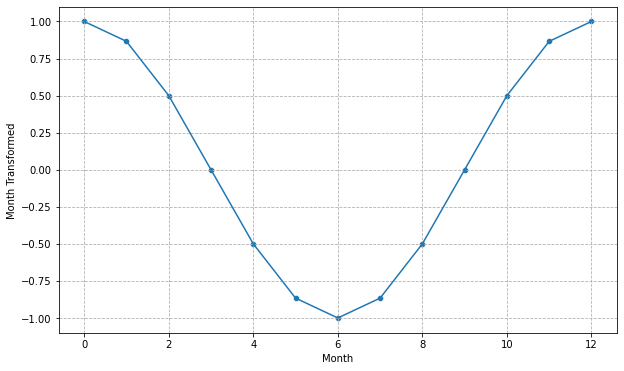

In [ ]:
def get_cyclical_month(month:int) -> float:
  return np.cos(2*np.pi*month / 12)  

months = list(range(0, 13))
months_= [get_cyclical_month(month) for month in months]

def plot_cyclical_month(months:list, months_transformed:list):
  fig, ax = plt.subplots(figsize=(10, 6))
  sns.lineplot(x=months, y=months_, ax=ax)
  sns.scatterplot(x=months, y=months_, ax=ax)
  ax.set_xlabel('Month'), ax.set_ylabel('Month Transformed')
  ax.grid(True, linestyle='--')

plot_cyclical_month(months, months_)


In [ ]:
df_train['month'] = get_cyclical_month(df_train['date'].dt.month)

## Scaling Numerical Features

In [ ]:
num_features = ['onpromotion', 'dcoilwtico']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('inputer', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

num_pipeline.fit(df_train[num_features])


Pipeline(steps=[('inputer', SimpleImputer()), ('scale', StandardScaler())])

In [ ]:
def get_scaled_numerical_df(df:pd.DataFrame, pipeline:Pipeline) -> pd.DataFrame:
  index = df.index
  num_features = pipeline.named_steps['inputer'].feature_names_in_
  return pd.DataFrame(
      pipeline.transform(df[num_features]),
      columns=num_features,
      index=index
  )

df_num_features_train = get_scaled_numerical_df(df_train, num_pipeline)

In [ ]:
df_num_features_test = get_scaled_numerical_df(df_test, num_pipeline)

In [ ]:
df_num_features_train.describe()

,onpromotion,dcoilwtico
count,3.000888e+06,3.000888e+06
mean,-5.311393e-17,1.671763e-15
std,1.000000e+00,1.000000e+00
min,-2.130122e-01,-1.922576e+00
25%,-2.130122e-01,-8.799602e-01
50%,-2.130122e-01,4.585618e-15
75%,-2.130122e-01,1.131630e+00
max,6.043084e+01,1.969456e+00


## Encoding Categorial Features

In [ ]:
cat_features = ['family', 'type', 'weekend']
df_train[cat_features].tail()

,family,type,weekend
id,,,
3000883,POULTRY,B,0
3000884,PREPARED FOODS,B,0
3000885,PRODUCE,B,0
3000886,SCHOOL AND OFFICE SUPPLIES,B,0
3000887,SEAFOOD,B,0


In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(drop='if_binary')
one_hot_encoder.fit(df_train[cat_features])

OneHotEncoder(drop='if_binary')

In [ ]:
def get_one_hot_encoder_df(encoder, df:pd.DataFrame) -> pd.DataFrame:
  index = df.index
  df = encoder.transform(df)
  df = pd.DataFrame(
      df.toarray(),
      columns = encoder.get_feature_names_out(),
      index=index
  )

  return df

df_cat_features_train = get_one_hot_encoder_df(one_hot_encoder, df_train[cat_features])
df_cat_features_train.tail()

,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,...,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E,weekend_1
id,,,,,,,,,,,,,,,,,,,,,
3000883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3000887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df_cat_features_test = get_one_hot_encoder_df(one_hot_encoder, df_test[cat_features])
df_cat_features_test.tail()

,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,...,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E,weekend_1
id,,,,,,,,,,,,,,,,,,,,,
3029395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3029396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3029397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3029398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3029399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df_features_train = df_num_features_train.merge(df_cat_features_train, left_index=True, right_index=True)
df_features_test  = df_num_features_test.merge(df_cat_features_test, left_index=True, right_index=True)
target            = df_train[target_column]

# Training

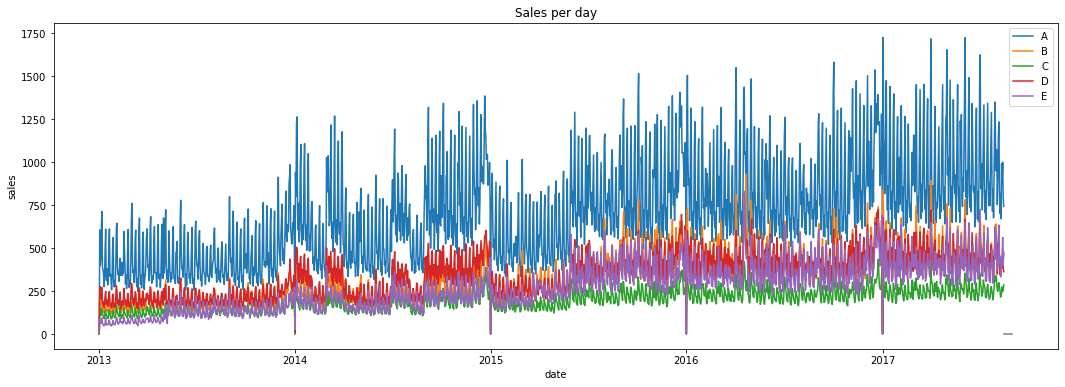

In [ ]:
def plot_sales(df:pd.DataFrame, figsize=(18,6)):
  df_plot = df.groupby(['type', 'date'])['sales'].mean().reset_index()
  fig, ax = plt.subplots(figsize=figsize)
  sns.lineplot(data=df_plot, x="date", y="sales", hue="type", ax=ax)
  sns.lineplot(data=df_test[['date']].assign(sales=0), x="date", y="sales", color='gray')
  ax.set_title('Sales per day')

plot_sales(df_train)

In [ ]:
train_index = df_train['date'] >= '2015-01-01'
df_features_train = df_features_train[train_index]
target = target[train_index]

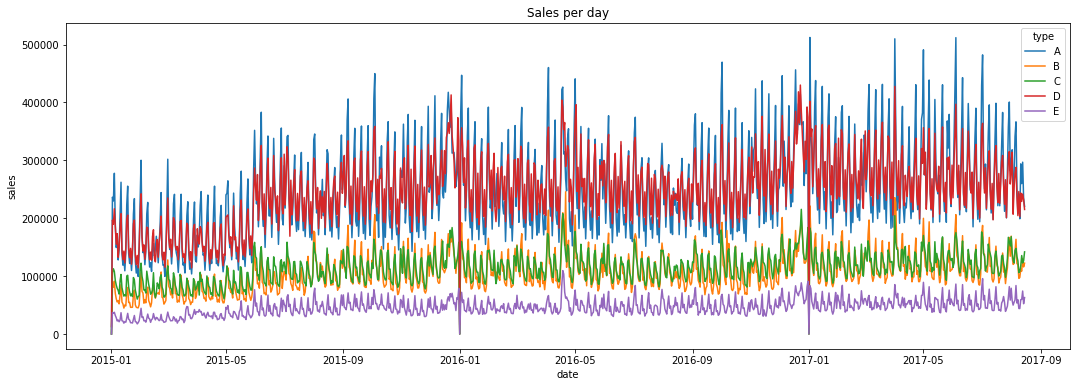

In [ ]:
plot_sales(df_train[train_index])

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
models = {
    'LinearReg': LinearRegression(),
    'RidgeReg': Ridge(),
    'LassoReg': Lasso(),
    # 'SGDRegressor':SGDRegressor(),
    # 'RandomForestRegressor':RandomForestRegressor(verbose=2, random_state=12345), # Takes too long
    # 'AdaBoostRegressor':AdaBoostRegressor(),
    # 'GradientBoostingRegressor':GradientBoostingRegressor(),
    # 'ExtraTreesRegressor':ExtraTreesRegressor(),
    # 'SVM_RBF':SVR(kernel='rbf', verbose=1),
    # 'SVM_POLY':SVR(kernel='poly'),
    # 'SVM_LINEAR':SVR(kernel='linear', max_iter=10**4, verbose=1),
    # 'SVM_SIG':SVR(kernel='sigmoid'),
}

In [ ]:
from sklearn.model_selection import KFold
from sklearn import metrics

kf = KFold(n_splits=2, shuffle=True, random_state=12345)

df_metrics = pd.DataFrame(columns=['model', 'fold', 'rmsle', 'mse', 'mae'])

for model_name, model in models.items():
  print (f'Training model {model_name}')
  for fold, (train_index, valid_index) in enumerate(kf.split(df_features_train)):
    X_train = df_features_train.iloc[train_index]
    y_train = target.iloc[train_index].values.reshape(1,-1)[0]
    X_valid = df_features_train.iloc[valid_index]
    y_valid = target.iloc[valid_index].values.reshape(1,-1)[0]

    # Fit model
    model.fit(X_train, y_train)

    # Make predictions of validation set
    y_pred = model.predict(X_valid)
    y_pred = np.clip(y_pred, a_min=0, a_max=np.max(y_pred))

    # Record fold metrics
    mse = metrics.mean_squared_error(y_valid, y_pred)
    mae = metrics.mean_absolute_error(y_valid, y_pred)
    rmsle = np.sqrt(metrics.mean_squared_log_error(y_valid, y_pred))

    df_metrics.loc[df_metrics.shape[0]] = [model_name, fold, rmsle, mse, mae]


Training model LinearReg
Training model RidgeReg
Training model LassoReg


In [ ]:
df_metrics

In [ ]:
eval_metric = 'rmsle'
df_metrics.groupby(['model']).mean().sort_values(by=eval_metric, ascending=True)

,rmsle,mse,r2,mae
model,,,,
RidgeReg,2.314934,609871.450327,0.603249,271.991160
LinearReg,2.332900,610721.971752,0.602699,273.423487
LassoReg,2.416823,612951.670029,0.601245,275.462132


# Fine Tunning

[Scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

In [ ]:
parameters = { # ridge regression
  'alpha': [1e-7, 1e-6, 1e-4, 1e-2, 1, 10],
  'solver': ['auto'],
  'random_state': [12345]
}

In [ ]:
# print ('Scoring Parameters')
# sorted(metrics.SCORERS.keys())
scoring = 'neg_mean_squared_log_error'

In [ ]:
from sklearn.model_selection import GridSearchCV

chosen_model = Ridge()
reg = GridSearchCV(chosen_model, parameters, scoring=scoring, n_jobs=-1)
reg.fit(df_features_train, target)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1e-07, 1e-06, 0.0001, 0.01, 1, 10],
                         'random_state': [12345], 'solver': ['auto']},
             scoring='neg_mean_squared_log_error')

In [ ]:
print ('Best Parameters:', reg.best_params_)
best_model = reg.best_estimator_

Best Parameters: {'alpha': 1e-07, 'random_state': 12345, 'solver': 'auto'}


# Generating Predictions

In [ ]:
pd.read_csv(os.path.join(filedir, 'sample_submission.csv')).tail()

,id,sales
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0
28511,3029399,0.0


In [ ]:
train_predictions = best_model.predict(df_features_train)
train_predictions = np.clip(train_predictions, a_min=0, a_max=np.max(train_predictions))

df_train_predictions = pd.DataFrame()
df_train_predictions['id'] = df_features_train.index
df_train_predictions['sales'] = target.values
df_train_predictions['sales_prediction'] = train_predictions

df_train_predictions


,id,sales,sales_prediction
0,24024,0.000,0.000000
1,24025,0.000,0.000000
2,24026,0.000,0.000000
3,24027,0.000,2662.757748
4,24028,0.000,0.000000
...,...,...,...
1703587,3000883,438.133,255.936888
1703588,3000884,154.553,29.188412
1703589,3000885,2419.729,3734.152447
1703590,3000886,121.000,39.817216


In [ ]:
test_predictions = best_model.predict(df_features_test[df_features_train.columns])
test_predictions = np.clip(test_predictions, a_min=0, a_max=np.max(test_predictions))

In [ ]:
df_test_predictions = pd.DataFrame()
df_test_predictions['id'] = df_features_test.index
df_test_predictions['sales'] = test_predictions

In [ ]:
df_test_predictions.tail()

,id,sales
28507,3029395,271.291243
28508,3029396,15.220755
28509,3029397,1579.677946
28510,3029398,55.171571
28511,3029399,0.000000


**Submitting predictions**

In [ ]:
now = pd.to_datetime('now').strftime('%Y-%m-%d-%H-%M-%S')
filename = f'./submission-{now}.csv'
df_test_predictions.to_csv(filename, index=False)


# References

- [Cross Validation in Time Series](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)
- [Time Series Modeling using Scikit, Pandas, and Numpy](https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1)
- [Predicting Sales: Time Series Analysis & Forecasting with Python](https://medium.com/analytics-vidhya/predicting-sales-time-series-analysis-forecasting-with-python-b81d3e8ff03f)